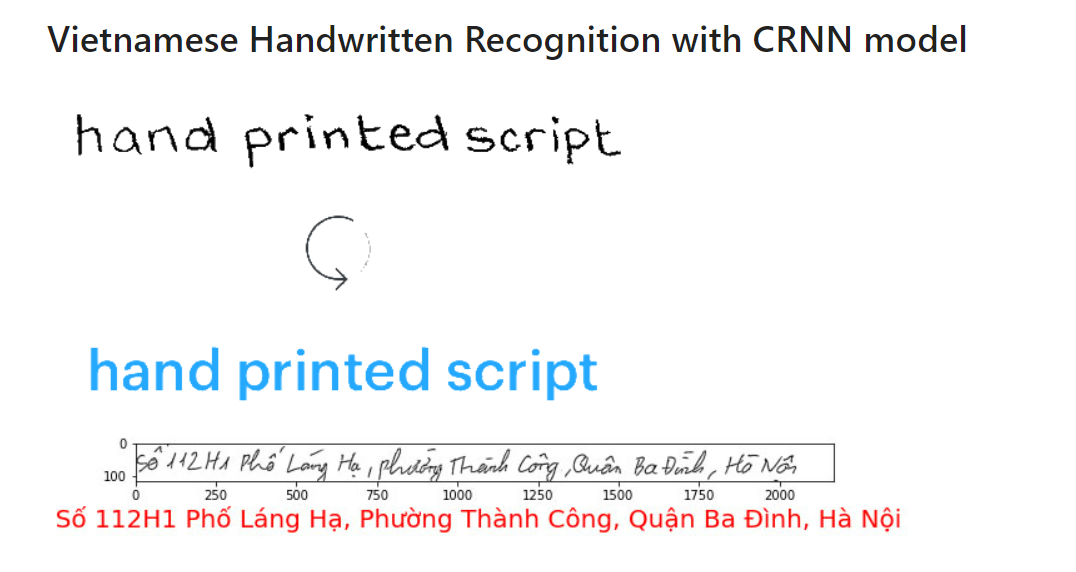

# SET UP

In [ ]:
import cv2 
import os
import pathlib
import numpy as np
import json
import matplotlib.pyplot as plt
import glob
import re
import zipfile
import shutil
import tensorflow as tf
from sklearn.model_selection import train_test_split
from google.colab import drive
from google.colab.patches import cv2_imshow

In [ ]:
# check if this code run on colab GPU else change runtime to GPU manually
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
  print(f'Found GPU at: {device_name}')

In [ ]:
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
# extract zip data
if os.path.isdir('vn_hcr') is True:
  shutil.rmtree('vn_hcr')
data_zip_path = '/content/gdrive/MyDrive/Data_ML_Study/vn_handwritten.zip'
with zipfile.ZipFile(data_zip_path, 'r') as zip_ref:
  zip_ref.extractall('vn_hcr/raw')

In [ ]:
# set path
current_path = pathlib.Path('./vn_hcr').absolute()
data_dir = os.path.join(str(current_path), 'data')
train_dir = os.path.join(data_dir, 'train')
test_dir = os.path.join(data_dir, 'test')
raw_dir = os.path.join(str(current_path), 'raw')
labels_dir = os.path.join(str(current_path), 'labels')

In [ ]:
# create data folder
os.makedirs(data_dir)
os.makedirs(train_dir)
os.makedirs(test_dir)
os.makedirs(labels_dir)

In [ ]:
# move labels.json file from raw dir to labels dir
shutil.move('/content/vn_hcr/raw/labels.json','/content/vn_hcr/labels/labels.json')

'/content/vn_hcr/labels/labels.json'

In [ ]:
# read label form json file
label_list = json.load(open('/content/vn_hcr/labels/labels.json'))
label_list

In [ ]:
# get all character from the label list
char_list = set()
for label in label_list.values():
  char_list.update(label)
char_list = sorted(char_list)

In [ ]:
# encoding each output word into digits of indexes
def encode_to_labels(txt):
  digit_list = []
  for index, char in enumerate(txt):
    try:
      digit_list.append(char_list.index(char))
    except:
      print("No found in char list: ", char)
  return digit_list

In [ ]:
# merge img path and its label into a dict
data_dict = {}
data_path = pathlib.Path(os.path.join(raw_dir))
for item in data_path.glob('**/*'):
  img_name = str(os.path.basename(item))
  label = label_list[img_name]
  data_dict[str(item)] = label
data_dict

In [ ]:
print("Total img found: ", len(data_dict.keys()))
print("Total labels found: ", len(data_dict.values()))
print("Total characters found: ", len(char_list))
print("Character:" + ''.join(char_list))

Total img found:  1838
Total labels found:  1838
Total characters found:  140
Character: #'()+,-./0123456789:ABCDEFGHIJKLMNOPQRSTUVWXYabcdeghiklmnopqrstuvwxyzÂÊÔàáâãèéêìíòóôõùúýăĐđĩũƠơưạảấầẩậắằẵặẻẽếềểễệỉịọỏốồổỗộớờởỡợụủỨứừửữựỳỵỷỹ


In [ ]:
img_path = list(data_dict.keys())
img_label = list(data_dict.values())

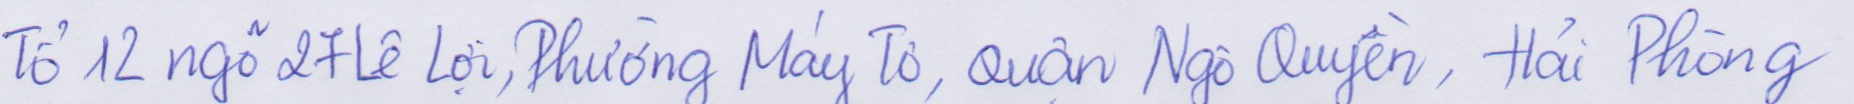

Tổ 12 ngõ 27 Lê Lợi, Phường Máy Tơ, Quận Ngô Quyền, Hải Phòng
0970_samples.png
[40, 120, 0, 11, 12, 0, 57, 51, 85, 0, 12, 17, 0, 32, 79, 0, 32, 127, 53, 6, 0, 36, 52, 96, 124, 57, 51, 0, 33, 74, 68, 0, 40, 95, 6, 0, 37, 64, 102, 57, 0, 34, 51, 84, 0, 37, 64, 68, 110, 57, 6, 0, 28, 98, 53, 0, 36, 52, 82, 57, 51]


(104, 1854, 3)

In [ ]:
# check an img
index = 1213
img = cv2.imread(img_path[index])
cv2_imshow(img)
print(img_label[index])
print(os.path.basename(img_path[index]))
print(encode_to_labels(img_label[index]))
img.shape

# PREPROCESS DATA

In [ ]:
# find max label len
list_label_len = []
for label in data_dict.values():
  list_label_len.append(len(label))
max_label_len = max(list_label_len)
max_label_len

69

In [ ]:
# split the data
train_img, valid_img = train_test_split(img_path, test_size = 0.2, random_state = 1)

In [ ]:
# time steps need to > than max_label len to avoid transition sequence error
TIME_STEPS = 200

In [ ]:
# training data
training_img = []
training_txt = []
train_input_length = []
train_label_length = []
orig_txt = []
max_width=0
for image in train_img:
    # read img, convert gray, resize to max size, blur, threshold, normalize
    img = cv2.cvtColor(cv2.imread(image), cv2.COLOR_BGR2GRAY)
    h, w = img.shape
    img = cv2.resize(img, (int(118/h*w), 118))
    h, w = img.shape
    if img.shape[1] > max_width:
        max_width = img.shape[1]
    img = np.pad(img, ((0,0),(0, 2167- w)), 'median')
    img = cv2.GaussianBlur(img, (5,5), 0)
    img = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 9, 5)
    img = np.expand_dims(img, axis = 2)
    img = img/255.
    # add
    label = data_dict[image]
    orig_txt.append(label)   
    train_label_length.append(len(label))
    train_input_length.append(TIME_STEPS)
    training_img.append(img)
    training_txt.append(encode_to_labels(label)) 

In [ ]:
max_width

2167

In [ ]:
# validation data
valid_img = []
valid_txt = []
valid_input_length = []
valid_label_length = []
valid_orig_txt = []
for image in valid_img:
    # read img, convert gray, resize to max size, blur, threshold, normalize
    #img = cv2.cvtColor(cv2.imread(val_img_path), cv2.COLOR_BGR2GRAY)
    #img = cv2.resize(img, (int(118/h*w), 118))
    #if img.shape[1] > resize_max_width:
        #resize_max_width = img.shape[1]
    img = cv2.cvtColor(cv2.imread(image), cv2.COLOR_BGR2GRAY)
    h, w = img.shape
    img = cv2.resize(img, (int(118/h*w), 118))
    h, w = img.shape
    img = np.pad(img, ((0,0), (0, 2167-w)), 'median')
    img = cv2.GaussianBlur(img, (5,5), 0)
    img = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 9, 5)
    img = np.expand_dims(img, axis = 2)
    img = img/255.
    # add
    label = data_dict[image]
    valid_orig_txt.append(label)   
    valid_label_length.append(len(label))
    valid_input_length.append(TIME_STEPS)
    valid_txt.append(encode_to_labels(label))

In [ ]:
max_label_len = TIME_STEPS

In [ ]:
# pad each output label to maximum text length
from tensorflow.keras.preprocessing.sequence import pad_sequences
train_padded_txt = pad_sequences(training_txt, maxlen = max_label_len, padding='post', value = 0)
valid_padded_txt = pad_sequences(valid_txt, maxlen = max_label_len, padding='post', value = 0)

In [ ]:
train_padded_txt[178]

array([ 40,  52,  84,  57,   0,  34,  51, 116,  48,   0,  39,  95,  57,
         0,  13,   6,   0,  44,  76,   0,  36,  52,  87,   0,  39,  95,
        57,   6,   0,  28,  64,  68, 113,  57,   0,  32,  75,  56,   0,
        28,  73,   6,   0,  32,  75,  56,   0,  90, 119,  57,  51,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   

# MODEL BUIDLING

In [ ]:
# import model, different layers and activation function 
from tensorflow.keras.layers import Dense, LSTM, Reshape, BatchNormalization, Input, Conv2D, MaxPool2D, Lambda, Bidirectional, Add, Activation, MaxPooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.activations import relu, sigmoid, softmax
import tensorflow.keras.backend as K
import tensorflow.keras as keras
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import CSVLogger, TensorBoard, ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

In [ ]:
'''
keras.backend.clear_session()
inputs = Input(shape = (128, max_width, 1)) # (128, 2350 , 1)
# 1st layer
conv_1 = Conv2D(64, (3,3), activation = 'relu', padding = 'same')(inputs) # (128, 2350, 64)
pool_1 = MaxPooling2D(3,3)(conv_1) # (64, 1175, 64)
# 2nd layer
conv_2 = Conv2D(128, (3,3), activation = 'relu', padding = 'same')(pool_1) # (64, 1175, 128)
pool_2 = MaxPooling2D(3,3)(conv_2) # (32, 587, 128)
# 3rd layer
conv_3 = Conv2D(256, (3,3), activation = 'relu', padding = 'same')(pool_2) # (32, 587, 256)
batch_norm_3 = BatchNormalization()(conv_3) # (32, 587, 256)
# 4th layer
conv_4 = Conv2D(256, (3,3), activation = 'relu', padding = 'same')(batch_norm_3) # (32, 587, 256)
batch_4 = BatchNormalization()(conv_4) # (31, 586, 256)
# 5th layer
conv_5 = Conv2D(512, (3,3), activation = 'relu', padding = 'same')(batch_4) # (31, 586, 512)
batch_norm_5 = BatchNormalization()(conv_5) # (31, 586, 512)
# 6th layer
conv_6 = Conv2D(512, (3,3), activation = 'relu', padding = 'same')(batch_norm_5) # (31, 586, 512)
batch_norm_6 = BatchNormalization()(conv_6) # (31, 586, 512)
# 7th layer
conv_7 = Conv2D(1024, (2,2), activation = 'relu')(batch_norm_6) # (14, 292, 1024)
pool_7 = MaxPooling2D(2,2)(conv_7) # (7, 146, 1024)
# 8th 
conv_8 = Conv2D(1024, (3,3), activation = 'relu')(pool_7) # (6, 145, 1024)
batch_norm_8 = BatchNormalization()(conv_8)
pool_8 = MaxPooling2D(4, 1)(conv_8) #(1, 140, 1024)
# Remove 1
squeezed = Lambda(lambda x: K.squeeze(x, 1))(pool_8) # (140, 1024)
# RNN
blstm_1 = Bidirectional(LSTM(1024, return_sequences = True, dropout = 0.2))(squeezed)
blstm_2 = Bidirectional(LSTM(1024, return_sequences = True, dropout = 0.2))(blstm_1)
# last layer which give us softmax character proba
outputs = Dense(len(char_list)+1, activation = 'softmax')(blstm_2) # (140, 141)
# create model
act_model = Model(inputs, outputs)
'''

"\nkeras.backend.clear_session()\ninputs = Input(shape = (128, max_width, 1)) # (128, 2350 , 1)\n# 1st layer\nconv_1 = Conv2D(64, (3,3), activation = 'relu', padding = 'same')(inputs) # (128, 2350, 64)\npool_1 = MaxPooling2D(3,3)(conv_1) # (64, 1175, 64)\n# 2nd layer\nconv_2 = Conv2D(128, (3,3), activation = 'relu', padding = 'same')(pool_1) # (64, 1175, 128)\npool_2 = MaxPooling2D(3,3)(conv_2) # (32, 587, 128)\n# 3rd layer\nconv_3 = Conv2D(256, (3,3), activation = 'relu', padding = 'same')(pool_2) # (32, 587, 256)\nbatch_norm_3 = BatchNormalization()(conv_3) # (32, 587, 256)\n# 4th layer\nconv_4 = Conv2D(256, (3,3), activation = 'relu', padding = 'same')(batch_norm_3) # (32, 587, 256)\nbatch_4 = BatchNormalization()(conv_4) # (31, 586, 256)\n# 5th layer\nconv_5 = Conv2D(512, (3,3), activation = 'relu', padding = 'same')(batch_4) # (31, 586, 512)\nbatch_norm_5 = BatchNormalization()(conv_5) # (31, 586, 512)\n# 6th layer\nconv_6 = Conv2D(512, (3,3), activation = 'relu', padding = 'same'

In [ ]:

# input shape 
inputs = Input(shape=(118, 2167, 1))
# Layer 1
x = Conv2D(64, (3,3), padding='same')(inputs)
x = MaxPool2D(pool_size=3, strides=3)(x)
x = Activation('relu')(x)
x_1 = x 
# Layer 2
x = Conv2D(128, (3,3), padding='same')(x)
x = MaxPool2D(pool_size=3, strides=3)(x)
x = Activation('relu')(x)
x_2 = x
# Layer 3
x = Conv2D(256, (3,3), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x_3 = x
# Layer 4
x = Conv2D(256, (3,3), padding='same')(x)
x = BatchNormalization()(x)
#x = Add()([x,x_3])
x = Activation('relu')(x)
x_4 = x
# Layer 5
x = Conv2D(512, (3,3), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x_5 = x
# Layer 6
x = Conv2D(512, (3,3), padding='same')(x)
x = BatchNormalization()(x)
#x = Add()([x,x_5])
x = Activation('relu')(x)
# Layer 7
x = Conv2D(1024, (3,3), padding='same')(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(3, 1))(x)
x = Activation('relu')(x)
x = MaxPool2D(pool_size=(3, 1))(x)
# remove the first dimension 
squeezed = Lambda(lambda x: K.squeeze(x, 1))(x)
# bidirectional LSTM layers with units=128
blstm_1 = Bidirectional(LSTM(512, return_sequences=True, dropout = 0.2))(squeezed)
blstm_2 = Bidirectional(LSTM(512, return_sequences=True, dropout = 0.2))(blstm_1)
# softmax character proprobility with timesteps 
outputs = Dense(len(char_list)+1, activation = 'softmax')(blstm_2)
# model 
act_model = Model(inputs, outputs)


In [ ]:
act_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 2350, 1)]    0         
                                                                 
 conv2d (Conv2D)             (None, 128, 2350, 64)     640       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 42, 783, 64)      0         
 )                                                               
                                                                 
 activation (Activation)     (None, 42, 783, 64)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 42, 783, 128)      73856     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 14, 261, 128)     0         
 2D)                                                         

In [ ]:
# define input shape
labels = Input(name='the_labels', shape=[max_label_len], dtype='float32')
# define the length of input and label for ctc
input_length = Input(name='input_length', shape=[1], dtype='int64')
label_length = Input(name='label_length', shape=[1], dtype='int64')

In [ ]:
 # define a ctc lambda function to take arguments and return ctc_bach_cost
def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args
    """
    labels: tensor (number of samples, max_string_length) containing the truth labels.
    y_pred: tensor (number of samples, time_steps, num_character_labels) containing the prediction, or output of the softmax.
    input_length: tensor (number of samples, 1) containing the sequence length for each batch item in y_pred.
    label_length: tensor (number of samples, 1) containing the sequence length for each batch item in y_true.
    """
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)
 
# out loss function (just take the inputs and put it in our ctc_batch_cost)
loss_out = Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')([outputs, labels, input_length, label_length])

# model to be used at training time
model = Model(inputs=[inputs, labels, input_length, label_length], outputs=loss_out)

In [ ]:
# ready ctc loss function and optimizers
model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer = 'adam')

# our callbacks hell to optimize our learning
callbacks = [
    TensorBoard(
        log_dir='./logs',
        histogram_freq=10,
        profile_batch=0,
        write_graph=True,
        write_images=False,
        update_freq="epoch"),
    ModelCheckpoint(
        filepath=os.path.join('checkpoint_weights.hdf5'),
        monitor='val_loss',
        save_best_only=True,
        save_weights_only=True,
        verbose=1),
    EarlyStopping(
        monitor='val_loss',
        min_delta=1e-8,
        patience=20,
        restore_best_weights=True,
        verbose=1),
    ReduceLROnPlateau(
        monitor='val_loss',
        min_delta=1e-8,
        factor=0.2,
        patience=10,
        verbose=1)
]
callbacks_list = callbacks

In [ ]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 2350,   0           []                               
                                1)]                                                               
                                                                                                  
 conv2d (Conv2D)                (None, 128, 2350, 6  640         ['input_1[0][0]']                
                                4)                                                                
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 42, 783, 64)  0           ['conv2d[0][0]']                 
                                                                                            

In [ ]:
# ready training data
training_img = np.array(training_img)
train_input_length = np.array(train_input_length)  # all must be equal length to T timesteps
train_label_length = np.array(train_label_length)  # different length (only the same in Captcha dataset)

# ready validating data
valid_img = np.array(valid_img)
valid_input_length = np.array(valid_input_length) # all must be equal length to T timesteps
valid_label_length = np.array(valid_label_length) # different length (only the same in Captcha dataset)

In [ ]:
batch_size = 32
epochs = 50

history = model.fit(x=[training_img, train_padded_txt, train_input_length, train_label_length], 
          y=np.zeros(len(training_img)),
          batch_size=batch_size, 
          epochs = epochs,
          validation_data = ([valid_img, valid_padded_txt, valid_input_length, valid_label_length], [np.zeros(len(valid_img))]),
          verbose = 1, callbacks = callbacks_list)

Epoch 1/50
46/46 [==============================] - 146s 3s/step - loss: 225.7547 - lr: 0.0010
Epoch 2/50
46/46 [==============================] - 99s 2s/step - loss: 200.9069 - lr: 0.0010
Epoch 3/50
46/46 [==============================] - 99s 2s/step - loss: 193.7773 - lr: 0.0010
Epoch 4/50
46/46 [==============================] - 99s 2s/step - loss: 174.8057 - lr: 0.0010
Epoch 5/50
46/46 [==============================] - 99s 2s/step - loss: 155.4270 - lr: 0.0010
Epoch 6/50
46/46 [==============================] - 99s 2s/step - loss: 137.9948 - lr: 0.0010
Epoch 7/50
46/46 [==============================] - 99s 2s/step - loss: 120.3514 - lr: 0.0010
Epoch 8/50
46/46 [==============================] - 99s 2s/step - loss: 104.1292 - lr: 0.0010
Epoch 9/50
46/46 [==============================] - 99s 2s/step - loss: 91.1621 - lr: 0.0010
Epoch 10/50
46/46 [==============================] - 99s 2s/step - loss: 78.5355 - lr: 0.0010
Epoch 11/50
46/46 [==============================] - 103s 2s